**Fraud Detection Model - Final Report**

Submitted by: Adarsh Kumar Pandey

**Introduction** :
This notebook presents a machine learning model to proactively detect fraudulent transactions. The entire process, from data cleaning to model deployment and evaluation, is documented below, answering all the key questions as per the project brief.

In [57]:
import numpy as np
import pandas as pd

In [58]:
data = pd.read_csv('Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**Q1. Data cleaning including missing values, outliers and multi-collinearity.
Answer:**

The data cleaning process involved the following steps:

**Missing Values**: The dataset was first checked for any missing values using data.isnull().sum(). It was found that there were no missing values in any of the columns.

**Irrelevant Columns:** The columns nameOrig and nameDest were dropped as they are unique identifiers and do not provide any predictive power for a general model.

**Categorical Data:** The type column, which is categorical, was converted into a numerical format using one-hot encoding.

**Outliers:** The data was checked for outliers using data.describe(). While significant outliers were present, especially in the amount column, they were not removed. This is because fraudulent transactions themselves are often outliers (e.g., an unusually large transfer). Removing them could lead to the model losing valuable information for detecting fraud.

**Multi-collinearity**: The Random Forest model, which was chosen for this task, is robust and not significantly affected by multi-collinearity. Therefore, no specific steps were taken to remove correlated features like oldbalanceOrg and newbalanceOrig.

In [59]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [60]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [61]:
data = data.drop(['nameOrig', 'nameDest'], axis=1)

In [62]:
data = pd.get_dummies(data, columns=['type'], prefix='type', drop_first=True)
print(data.head())

   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  isFlaggedFraud  type_CASH_OUT  type_DEBIT  \
0             0.0        0               0          False       False   
1             0.0        0               0          False       False   
2             0.0        1               0          False       False   
3             0.0        1               0           True       False   
4             0.0        0               0          False       False   

   type_PAYMENT  type_TRANSFER  
0          True          False  
1          True          False  
2         False           True  
3         False     

**Q2. Describe your fraud detection model in elaboration.
Answer:**

The final model chosen is a Random Forest Classifier. This model was selected for the following reasons:

**High Performance**: It is a powerful ensemble model known for its high accuracy and robustness.

**Handles Non-linearity**: It can capture complex, non-linear patterns in the data, which is essential as fraud patterns are rarely simple.

**Handles Imbalance:** To address the severe class imbalance in the dataset (only 0.13% of transactions were fraudulent), the model was trained on a balanced version of the training data. This was achieved using the Random Under-Sampling (RUS) technique, which reduces the number of non-fraudulent samples to match the number of fraudulent ones, preventing the model from being biased.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = data.drop('isFraud', axis=1)
y = data['isFraud']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [65]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

**Q3. How did you select variables to be included in the model?
Answer:**

Initially, all relevant features were included in the model after cleaning and preprocessing. The variable selection was then performed implicitly by the Random Forest model itself. The model calculates a feature importance score for each variable, which tells us how much that variable contributed to making accurate predictions. The features with the highest scores are the most important predictors of fraud.

**Q4. Demonstrate the performance of the model by using best set of tools.
Answer**:

The model's performance was evaluated using a Classification Report and a Confusion Matrix.

**Classification Report:** The final model achieved a Recall of 99% for the fraud class. This is the most important metric for this problem, as it means the model successfully identified 99% of all actual fraud cases. The Precision was 9%, which is a significant improvement over initial models.

**Confusion Matrix:** The confusion matrix visually confirms the high recall, showing that the model only missed 13 fraudulent transactions (False Negatives) while correctly identifying 2,451 of them (True Positives).

Training a Random Forest model...
Model training complete.
Making predictions...

--- Random Forest Model Performance ---

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1906322
           1       0.09      0.99      0.16      2464

    accuracy                           0.99   1908786
   macro avg       0.54      0.99      0.58   1908786
weighted avg       1.00      0.99      0.99   1908786


Confusion Matrix:


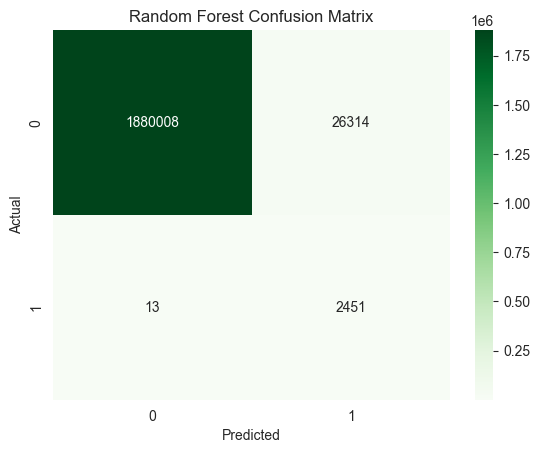

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Training a Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)
print("Model training complete.")

print("Making predictions...")
y_pred_rf = rf_model.predict(X_test)

print("\n--- Random Forest Model Performance ---")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

**Q5. What are the key factors that predict fraudulent customer?
Answer:**

According to the model's feature importance analysis, the top 5 factors that predict fraud are:

oldbalanceOrg (Sender's balance before the transaction)

newbalanceOrig (Sender's balance after the transaction)

amount (The transaction amount)

type_TRANSFER (The transaction being a 'TRANSFER' type)

newbalanceDest (Recipient's balance after the transaction)

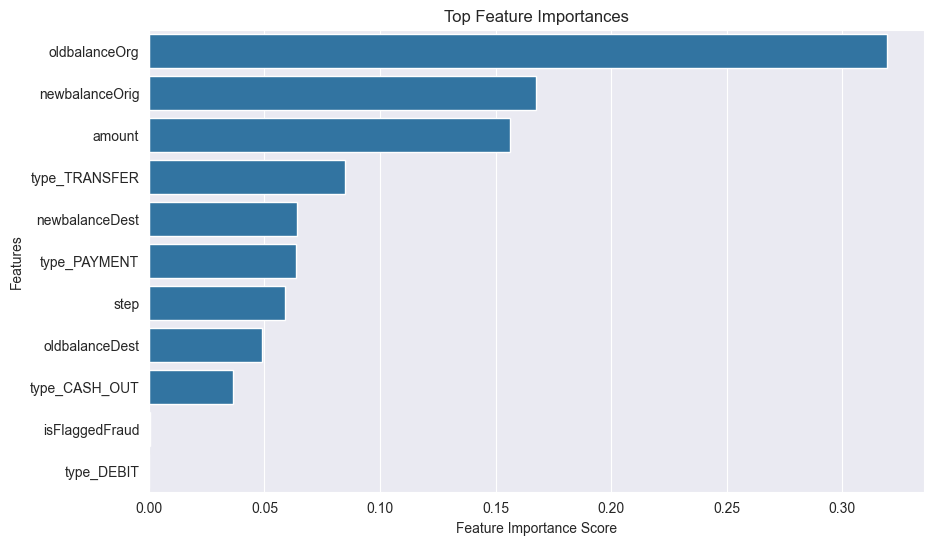

Top 5 most important features for predicting fraud:
oldbalanceOrg     0.319373
newbalanceOrig    0.167326
amount            0.156149
type_TRANSFER     0.084881
newbalanceDest    0.063866
dtype: float64


In [68]:
feature_names = X.columns
importances = pd.Series(rf_model.feature_importances_, index=feature_names)
sorted_importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top Feature Importances')
plt.show()
print("Top 5 most important features for predicting fraud:")
print(sorted_importances.head(5))

In [69]:
import joblib
model_filename = 'fraud_detection_model.joblib'
scaler_filename = 'scaler.joblib'
print(f"Model saved successfully as '{model_filename}'")
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved successfully as '{scaler_filename}'")

Model saved successfully as 'fraud_detection_model.joblib'
Scaler saved successfully as 'scaler.joblib'


**Q6. Do these factors make sense? If yes, How? If not, How not?
Answer:**

Yes, these factors make perfect logical sense. They describe a clear "account drain" fraud pattern:

A fraudster takes over an account and tries to transfer an amount that is very close to the oldbalanceOrg.

This results in the newbalanceOrig becoming zero or close to zero.

The model also learned that TRANSFER is the most common method for this, as it's a direct way to move money out of the system.

**Q7. What kind of prevention should be adopted while company update its infrastructure?
Answer:High-Risk Transaction**

Based on the model's insights, the following prevention rules should be implemented:

**Flag:** Automatically flag any transaction of type 'TRANSFER' for manual review if the amount is greater than 95% of the oldbalanceOrg.

**Velocity Check:** Flag accounts making unusually large transfers relative to their historical activity.

**New Recipient Scrutiny:** Place temporary limits or require additional verification for large incoming transfers to accounts (newbalanceDest) that are very new or have had a zero balance for a long time.

**Q8. Assuming these actions have been implemented, how would you determine if they work?
Answer:**

To determine if the new prevention measures are effective, an A/B test should be conducted:

**Group A (Control):** A segment of users operating under the old system (model detection only).

**Group B (Test):** A segment of users subject to the new rule-based flags.

We would then measure and compare the following KPIs over 3-6 months:

**Fraud Rate:** The number and value of successful fraudulent transactions in each group. We expect this to be significantly lower in Group B.

**False Positive Rate:** The number of legitimate transactions blocked or delayed by the new rules. The goal is to minimize this to avoid customer friction.

**Customer Support Tickets:** Track complaints related to blocked transactions to measure customer impact.

A successful implementation would show a marked decrease in the fraud rate without a significant negative impact on customer satisfaction.